* SSD by chainercv
* See
    * https://arxiv.org/abs/1512.02325
    * https://github.com/chainer/chainercv/tree/master/examples/ssd

In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import chainer
import chainercv
from chainercv.datasets import voc_bbox_label_names, VOCBboxDataset
from chainercv.visualizations import vis_bbox

* Download Pascal VOC 2007 dataset using chainercv.

In [3]:
dataset = VOCBboxDataset(year='2007')

From: http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
To: /root/.chainer/dataset/_dl_cache/1b8e6e3f7ee4cdd7960310d1b25d2f4c
  %   Total    Recv       Speed  Time left
100  439MiB  439MiB   7811KiB/s    0:00:00

* Plot img, ground truth bb, label

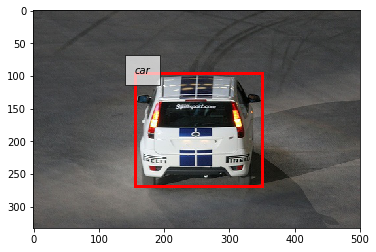

In [10]:
img, bbox, label = dataset[0]
vis_bbox(img, bbox, label, label_names=voc_bbox_label_names)
plt.show()

* Plot img, predict bb, label
* Load pre-trained model

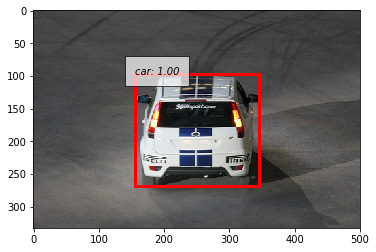

In [24]:
img, _, _ = dataset[0]
img = img[np.newaxis]
model = chainercv.links.SSD300(pretrained_model='voc0712')
bboxes, labels, scores = model.predict(img)
vis_bbox(img[0], bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
plt.show()

* Train

In [3]:
import copy
from chainer.training import extensions

In [4]:
class MultiboxTrainChain(chainer.Chain):

    def __init__(self, model, alpha=1, k=3):
        
        super(MultiboxTrainChain, self).__init__()
        with self.init_scope():
            self.model = model
        self.alpha = alpha
        self.k = k

    def __call__(self, imgs, gt_mb_locs, gt_mb_labels):
        
        mb_locs, mb_confs = self.model(imgs)
        loc_loss, conf_loss = chainercv.links.model.ssd.multibox_loss(mb_locs, mb_confs, gt_mb_locs, gt_mb_labels, self.k)
        loss = loc_loss * self.alpha + conf_loss
        chainer.reporter.report({'loss': loss, 'loss/loc': loc_loss, 'loss/conf': conf_loss}, self)
        return loss

In [5]:
class Transform(object):

    def __init__(self, coder, size, mean):
        
        # to send cpu, make a copy
        self.coder = copy.copy(coder)
        self.coder.to_cpu()

        self.size = size
        self.mean = mean

    def __call__(self, in_data):
        
        # There are five data augmentation steps
        # 1. Color augmentation
        # 2. Random expansion
        # 3. Random cropping
        # 4. Resizing with random interpolation
        # 5. Random horizontal flipping

        img, bbox, label = in_data

        # 1. Color augmentation
        img = chainercv.links.model.ssd.random_distort(img)

        # 2. Random expansion
        if np.random.randint(2):
            img, param = chainercv.transforms.random_expand(img, fill=self.mean, return_param=True)
            bbox = chainercv.transforms.translate_bbox(bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

        # 3. Random cropping
        img, param = chainercv.links.model.ssd.random_crop_with_bbox_constraints(img, bbox, return_param=True)
        bbox, param = chainercv.transforms.crop_bbox(
            bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],
            allow_outside_center=False, return_param=True)
        label = label[param['index']]

        # 4. Resizing with random interpolatation
        _, H, W = img.shape
        img = chainercv.links.model.ssd.resize_with_random_interpolation(img, (self.size, self.size))
        bbox = chainercv.transforms.resize_bbox(bbox, (H, W), (self.size, self.size))

        # 5. Random horizontal flipping
        img, params = chainercv.transforms.random_flip(img, x_random=True, return_param=True)
        bbox = chainercv.transforms.flip_bbox(bbox, (self.size, self.size), x_flip=params['x_flip'])

        # Preparation for SSD network
        img -= self.mean
        mb_loc, mb_label = self.coder.encode(bbox, label)

        return img, mb_loc, mb_label

In [6]:
gpu = 0
epoch_num = 10
batch_size = 32

model = chainercv.links.SSD300(n_fg_class=len(voc_bbox_label_names), pretrained_model='imagenet')
model.use_preset('evaluate')
train_chain = MultiboxTrainChain(model)

if gpu >= 0:
    chainer.cuda.get_device_from_id(gpu).use()
    model.to_gpu()

train_dataset = chainer.datasets.TransformDataset(VOCBboxDataset(year='2007', split='train'), Transform(model.coder, model.insize, model.mean))
train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
valid_dataset = VOCBboxDataset(year='2007', split='test')
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size, repeat=False, shuffle=False)

optimizer = chainer.optimizers.Adam()
optimizer.setup(train_chain)

In [7]:
updater = chainer.training.updaters.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (epoch_num, 'epoch'), out='result')
trainer.extend(chainercv.extensions.DetectionVOCEvaluator(valid_iter, model, use_07_metric=True, label_names=voc_bbox_label_names), trigger=(5, 'epoch'))
log_interval = (1, 'epoch')
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.PrintReport(['epoch', 'iteration', 'lr', 'main/loss', 'main/loss/loc', 'main/loss/conf', 'validation/main/map', 'elapsed_time']), trigger=log_interval)
trainer.run()

epoch       iteration   lr          main/loss   main/loss/loc  main/loss/conf  validation/main/map  elapsed_time
1           79          0.000275742  16.8608     3.75257        13.1082                              121.402       
2           157         0.000381265  7.56173     2.53181        5.02993                              239.886       
3           235         0.000457736  7.35816     2.46636        4.89181                              358.101       
4           313         0.000518522  7.29235     2.39583        4.89652                              476.253       
5           391         0.000568992  7.19464     2.35675        4.8379          0.0075328            915.318       
6           469         0.00061198  7.1203      2.32654        4.79376                              1035.82       
7           548         0.000649657  7.07399     2.28577        4.78822                              1157.25       
8           626         0.000682232  7.02168     2.26326        4.75843     

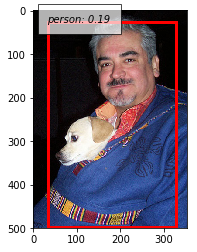

In [18]:
img, _, _ = valid_dataset[0]
img = img[np.newaxis]
model.score_thresh = 0.18
bboxes, labels, scores = model.predict(img)
vis_bbox(img[0], bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
plt.show()

* Evaluate

In [20]:
valid_iter.reset()
evaluator = chainercv.extensions.DetectionVOCEvaluator(valid_iter, model, label_names=voc_bbox_label_names)
result = evaluator()
result

{'main/map': 0.0023633548846106467,
 'main/ap/aeroplane': 0.03275460155765758,
 'main/ap/bicycle': 0.0,
 'main/ap/bird': 0.0,
 'main/ap/boat': 0.0,
 'main/ap/bottle': 0.0,
 'main/ap/bus': 0.0,
 'main/ap/car': 0.0022314976982782545,
 'main/ap/cat': 0.0,
 'main/ap/chair': 0.0,
 'main/ap/cow': 0.0,
 'main/ap/diningtable': 0.0,
 'main/ap/dog': 0.0,
 'main/ap/horse': 0.0,
 'main/ap/motorbike': 0.0,
 'main/ap/person': 0.012280998436277096,
 'main/ap/pottedplant': 0.0,
 'main/ap/sheep': 0.0,
 'main/ap/sofa': 0.0,
 'main/ap/train': 0.0,
 'main/ap/tvmonitor': 0.0}

In [21]:
valid_iter.reset()
pretrained_model = chainercv.links.SSD300(pretrained_model='voc0712')
evaluator = chainercv.extensions.DetectionVOCEvaluator(valid_iter, pretrained_model, label_names=voc_bbox_label_names)
result = evaluator()
result

{'main/map': 0.6622384936970079,
 'main/ap/aeroplane': 0.7006234221375536,
 'main/ap/bicycle': 0.7448847973328602,
 'main/ap/bird': 0.6358051280595165,
 'main/ap/boat': 0.5694064058498565,
 'main/ap/bottle': 0.2781277756037822,
 'main/ap/bus': 0.7882519684840986,
 'main/ap/car': 0.7608275990128093,
 'main/ap/cat': 0.8420399476228143,
 'main/ap/chair': 0.4000064656697345,
 'main/ap/cow': 0.6287194071304874,
 'main/ap/diningtable': 0.6942078304177143,
 'main/ap/dog': 0.8049751500725344,
 'main/ap/horse': 0.7979367920512144,
 'main/ap/motorbike': 0.7617485356989546,
 'main/ap/person': 0.6421537607325789,
 'main/ap/pottedplant': 0.32497128777547873,
 'main/ap/sheep': 0.6537359173013685,
 'main/ap/sofa': 0.6989941660931727,
 'main/ap/train': 0.8518874760337404,
 'main/ap/tvmonitor': 0.6654660408598898}

In [22]:
!python --version

Python 3.6.3


In [23]:
!pip freeze

absl-py==0.2.0
astor==0.6.2
backcall==0.1.0
bleach==1.5.0
boto==2.49.0
boto3==1.7.73
botocore==1.10.73
bz2file==0.98
certifi==2018.4.16
chainer==4.0.0
chainercv==0.10.0
chardet==3.0.4
cntk-gpu==2.5.1
cupy==4.0.0
cycler==0.10.0
Cython==0.28.2
decorator==4.3.0
dm-sonnet==1.20
docutils==0.14
edward==1.3.5
entrypoints==0.2.3
fastrlock==0.3
filelock==3.0.4
future==0.16.0
gast==0.2.0
gensim==3.5.0
graphviz==0.8.3
grpcio==1.11.0
h5py==2.7.1
html5lib==0.9999999
idna==2.6
ipykernel==4.8.2
ipython==6.3.1
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.0
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==5.2.3
jupyter-console==5.2.0
jupyter-core==4.4.0
Keras==2.1.6
kiwisolver==1.0.1
Lasagne==0.2.dev1
leveldb==0.194
Mako==1.0.7
Markdown==2.6.11
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
mxnet-cu90==1.1.0.post0
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
nose==1.3.7
notebook==5.4.1
numpy==1.14.3
pandas==0.22.0
pandocfilters==1.4.2
parso==0

In [24]:
!cat /proc/driver/nvidia/version

NVRM version: NVIDIA UNIX x86_64 Kernel Module  384.111  Tue Dec 19 23:51:45 PST 2017
GCC version:  gcc version 5.4.0 20160609 (Ubuntu 5.4.0-6ubuntu1~16.04.10) 


In [25]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176
